In [329]:
# 01_anac_ca.ipynb

In [378]:
### IMPORT ###
import pandas as pd
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [331]:
### LOCAL IMPORT ###
from config import config_reader
from utility_manager.utilities import json_to_list_dict, json_to_sorted_dict, check_and_create_directory, get_values_from_dict_list, df_read_csv, df_print_details, script_info

In [437]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
# print(yaml_config) # debug

# Directories
od_anac_dir = str(yaml_config["OD_ANAC_DIR"])
od_istat_dir = str(yaml_config["OD_ISTAT_DIR"])
od_bdap_dir = str(yaml_config["OD_BDAP_DIR"])
plots_dir = str(yaml_config["PLOTS_DIR"])
stats_dir = str(yaml_config["OD_STATS_DIR"])

# CSV
csv_sep = str(yaml_config["CSV_FILE_SEP"])

# ISTAT files
istat_dimension_file = str(yaml_config["OD_ISTAT_DIM_FILE"])
istat_nuts_file = str(yaml_config["OD_ISTAT_NUTS_FILE"])

# Open BDAP
bdap_file = str(yaml_config["OD_BDAP_FILE"])

# ANAC files and configuration
tender_main_file = str(yaml_config["TENDER_MAIN_TABLE"])
conf_file_cols_exc = str(yaml_config["CONF_COLS_EXCL_FILE"]) # JSON with columns to be excluded from reading
conf_file_cols_type = str(yaml_config["CONF_COLS_TYPE_FILE"]) # JSON with column types  

# STATS 
conf_file_stats = str(yaml_config["STATS_CONF_FILE"]) # JSON with column types  


In [410]:
### FUNCTIONS ###
def extract_top_k_and_sum_others(df: pd.DataFrame, column_name: str, k: int) -> pd.DataFrame:
    """
    Extract the top k most frequent distinct values from the specified column of the dataframe, compute the sum of the remaining values if there are more than k distinct values, and calculate the percentage of each value relative to the total.

    Parameters:
        df (DataFrame): The input dataframe.
        column_name (str): The name of the column from which to extract the top values.
        k (int): The number of top values to extract.

    Returns:
        DataFrame: A dataframe containing the most frequent values and their counts, as well as the percentage of each value relative to the total, rounded to 2 decimal places.
    """

    # Calculate the frequency of values in the column
    value_counts = df[column_name].value_counts()
    
    # Calculate the total count of all values
    total_count = value_counts.sum()
    
    # Number of distinct values
    num_distinct_values = len(value_counts)
    
    if num_distinct_values > k:
        # Extract the top k most frequent values
        top_k_values = value_counts.head(k)
        # Calculate the sum of the other remaining distinct values
        sum_others = value_counts.iloc[k:].sum()
        
        # Create a new dataframe with the results
        result = pd.DataFrame(top_k_values).reset_index()
        result.columns = [column_name, f'{column_name}_count']
        
        # Add the sum of the other values as the k+1th value
        result.loc[k] = ['Others', sum_others]
    else:
        # Use all distinct values if there are k or fewer
        result = pd.DataFrame(value_counts).reset_index()
        result.columns = [column_name, f'{column_name}_count']
    
    # Calculate the percentage of each value relative to the total
    result[f'{column_name}_percentage'] = (result[f'{column_name}_count'] / total_count * 100).round(2)
    
    return result

In [446]:
def create_pie_chart_from_result(df: pd.DataFrame, labels_column: str, values_column: str, plot_dir:str, k:int):
    """
    Create a pie chart based on the specified values column of the given DataFrame.

    Parameters:
        df (DataFrame): The input dataframe containing the labels and values for the pie chart.
        labels_column (str): The name of the column to use for the pie chart labels.
        values_column (str): The name of the column to use for the pie chart values.
        plot_dir (str): The name of the directory in which save the plot.
        k (int): The top-k value.

    Returns:
        None
    """
    # Extract data for the pie chart
    labels = df[labels_column]
    values = df[values_column]

    # Set font properties to Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 11})
    plt.title(f"Percentage distribution of columns '{labels_column}' (top k={str(k)}) \n")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Save the figure
    file_name = labels_column.replace(" ","_")
    file_path = Path(plot_dir) / f"{file_name}.png"
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0.1)

    # Show the plot
    plt.show()

In [333]:
### MAIN ###
print()
print(f"*** PROGRAM START ***")
print()


*** PROGRAM START ***



In [ ]:
print(">> Creating output directory")
check_and_create_directory()

In [334]:
print(">> Reading the configuration files")
print("File (columns excluded):", conf_file_cols_exc)
list_col_exc_dic = json_to_list_dict(conf_file_cols_exc)
# print(list_col_exc_dic) # debug
print("File (columns type):", conf_file_cols_type)
list_col_type_dic = json_to_sorted_dict(conf_file_cols_type)
# print(list_col_type_dic) # debug

>> Reading the configuration files
File (columns excluded): conf_cols_read_excluded.json
File (columns type): conf_cols_type.json


In [335]:
print(">> Reading ISTAT files")
dic_t = {"istat_code":object} # force the istat_code feature to be a string
# Municipality dimension
path_istat_dim = Path(od_istat_dir) / istat_dimension_file
print("File:", path_istat_dim)
list_col = ["Codice Regione","istat_code","Denominazione (Italiana e straniera)","Superficie territoriale (kmq) al 01/01/2023","Popolazione legale 2021 (31/12/2021)","Comune litoraneo","Comune isolano","Zone costiere","Grado di urbanizzazione"]
df_istat_dim = pd.read_csv(path_istat_dim, sep=csv_sep, usecols=list_col, dtype=dic_t, low_memory=False)
print("ISTAT municipalities dataframe dimension:", df_istat_dim.shape)
print("ISTAT municipalities shape:", df_istat_dim.columns)
print("---")
# Municipality NUTS
path_istat_nuts = Path(od_istat_dir) / istat_nuts_file
print("File:", path_istat_nuts)
list_col = ["Codice Regione","Codice Provincia (Storico)(1)","istat_code","Codice Ripartizione Geografica","Ripartizione geografica","Denominazione Regione","Codice Comune numerico con 103 province (dal 1995 al 2005)","Codice Catastale del comune","Codice NUTS1 2021","Codice NUTS2 2021 (3)","Codice NUTS3 2021","Codice NUTS1 2024","Codice NUTS2 2024 (3)","Codice NUTS3 2024"]
df_istat_nuts = pd.read_csv(path_istat_nuts, sep=csv_sep, dtype=dic_t, low_memory=False)
print("ISTAT NUTS shape:", df_istat_nuts.shape)
print("ISTAT NUTS columns:", df_istat_nuts.columns)

>> Reading ISTAT files
File: open_data_istat/istat_dimensions.csv
ISTAT municipalities dataframe dimension: (7900, 9)
ISTAT municipalities shape: Index(['Codice Regione', 'istat_code', 'Denominazione (Italiana e straniera)',
       'Superficie territoriale (kmq) al 01/01/2023',
       'Popolazione legale 2021 (31/12/2021)', 'Comune litoraneo',
       'Comune isolano', 'Zone costiere', 'Grado di urbanizzazione'],
      dtype='object')
---
File: open_data_istat/istat_nuts.csv
ISTAT NUTS shape: (7896, 26)
ISTAT NUTS columns: Index(['Codice Regione',
       'Codice dell'Unita territoriale sovracomunale (valida a fini statistici)',
       'Codice Provincia (Storico)(1)', 'Progressivo del Comune (2)',
       'istat_code', 'Denominazione (Italiana e straniera)',
       'Denominazione in italiano', 'Denominazione altra lingua',
       'Codice Ripartizione Geografica', 'Ripartizione geografica',
       'Denominazione Regione',
       'Denominazione dell'Unita territoriale sovracomunale (valida 

In [336]:
# Join the ISTAT tables
df_istat = pd.merge(left=df_istat_dim, right=df_istat_nuts, how="inner", on="istat_code")

In [337]:
# Unique ISTAT dataframe
df_istat

,Codice Regione_x,istat_code,Denominazione (Italiana e straniera)_x,Superficie territoriale (kmq) al 01/01/2023,Popolazione legale 2021 (31/12/2021),Comune litoraneo,Comune isolano,Zone costiere,Grado di urbanizzazione,Codice Regione_y,...,Codice Comune numerico con 110 province (dal 2010 al 2016),Codice Comune numerico con 107 province (dal 2006 al 2009),Codice Comune numerico con 103 province (dal 1995 al 2005),Codice Catastale del comune,Codice NUTS1 2021,Codice NUTS2 2021 (3),Codice NUTS3 2021,Codice NUTS1 2024,Codice NUTS2 2024 (3),Codice NUTS3 2024
0,1,001001,Agliè,"13,29",2.562,0,0,0,2,1,...,1001,1001,1001,A074,ITC,ITC1,ITC11,ITC,ITC1,ITC11
1,1,001002,Airasca,"15,78",3.660,0,0,0,3,1,...,1002,1002,1002,A109,ITC,ITC1,ITC11,ITC,ITC1,ITC11
2,1,001003,Ala di Stura,"45,76",467,0,0,0,3,1,...,1003,1003,1003,A117,ITC,ITC1,ITC11,ITC,ITC1,ITC11
3,1,001004,Albiano d'Ivrea,"11,38",1.637,0,0,0,3,1,...,1004,1004,1004,A157,ITC,ITC1,ITC11,ITC,ITC1,ITC11
4,1,001006,Almese,"17,80",6.331,0,0,0,2,1,...,1006,1006,1006,A218,ITC,ITC1,ITC11,ITC,ITC1,ITC11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7887,20,111103,Villaputzu,"180,68",4.509,1,0,1,3,20,...,92097,92097,92097,L998,ITG,ITG2,ITG2H,ITG,ITG2,ITG2H
7888,20,111104,Villasalto,"129,87",989,0,0,0,3,20,...,92098,92098,92098,M016,ITG,ITG2,ITG2H,ITG,ITG2,ITG2H
7889,20,111105,Villasimius,"57,42",3.705,1,0,1,3,20,...,92100,92100,92100,B738,ITG,ITG2,ITG2H,ITG,ITG2,ITG2H
7890,20,111106,Villasor,"86,37",6.599,0,0,0,2,20,...,92101,92101,92101,M025,ITG,ITG2,ITG2H,ITG,ITG2,ITG2H


In [338]:
# Open BDAP
print(">> Reading Oepn BDAP files")
dic_t = {"CF":object} # force the tax_code feature to be a string
# Municipality dimension
path_bdap_file = Path(od_bdap_dir) / bdap_file
print("File:", path_bdap_file)
df_bdap = pd.read_csv(path_bdap_file, sep=csv_sep, dtype=dic_t, low_memory=False)
# Fix tax_code column (CF to tax_code)
df_bdap = df_bdap.rename(columns={"CF":"tax_code"})
print("Open BDAP shape:", df_bdap.shape)
print("Open BDAP columns:", df_bdap.columns)

>> Reading Oepn BDAP files
File: open_data_bdap/bdap_enti.csv
Open BDAP shape: (37528, 63)
Open BDAP columns: Index(['Id_Ente', 'Denominazione', 'tax_code', 'PIva', 'Data_Istituzione',
       'Data_Cessazione', 'Codice_ATECO', 'Descr_Codice_ATECO',
       'Codice_Forma_Giuridica', 'Descr_Forma_Giuridica', 'Telefono', 'FAX',
       'URL', 'Nome_Resp', 'Cogn_Resp', 'Titolo_Resp', 'Indirizzo', 'CAP',
       'Codice_ISTAT_Comune', 'Codice_Comune', 'Dizione_Comune',
       'Codice_Catastale', 'Codice_Provincia', 'Dizione_Provincia',
       'Sigla_Provincia', 'Codice_Regione', 'Dizione_Regione', 'Codice_Zona',
       'Dizione_zona', 'Stato_Partecipazione', 'Codice_Ente_SIOPE',
       'Id_Tipologia_SIOPE', 'Codice_Tipologia_SIOPE', 'Descr_Tipologia_SIOPE',
       'Data_Inclusione_SIOPE', 'Data_Esclusione_SIOPE', 'Codice_Ente_IPA',
       'Id_Categoria_IPA', 'Codice_Categoria_IPA', 'Descr_Categoria_IPA',
       'Codice_Tipologia_IPA', 'Descr_Tipologia_IPA', 'Data_Inclusione_IPA',
       'Data_

In [339]:
# ANAC - Tender
print(">> Reading ANAD OD files")
print("File:", tender_main_file)
path_file_od = Path(od_anac_dir) / tender_main_file
# Get the columns excluded from the configuration list
list_col_exc = get_values_from_dict_list(list_col_exc_dic, tender_main_file)
list_col_exc_len = len(list_col_exc)
print("Columns exluded from the dataframe:", list_col_exc_len)
df_od = df_read_csv(od_anac_dir, tender_main_file, list_col_exc, list_col_type_dic, None, csv_sep)
print(f"> Updating main tender file '{tender_main_file}'")
df_od['cpv_division'] = df_od['cod_cpv'].apply(lambda x: x[:2] if pd.notnull(x) else None)
df_od['accordo_quadro'] = df_od['cig_accordo_quadro'].apply(lambda x: 1 if pd.notna(x) else 0)
df_od = df_od.rename(columns={"cf_amministrazione_appaltante":"tax_code"})
print("ANAC - Tenders dataframe columns:", df_od.columns)

>> Reading ANAD OD files
File: bando_cig_2016-2023.csv
Columns exluded from the dataframe: 31
> Updating main tender file 'bando_cig_2016-2023.csv'
ANAC - Tenders dataframe columns: Index(['cig', 'cig_accordo_quadro', 'numero_gara', 'oggetto_gara',
       'importo_complessivo_gara', 'n_lotti_componenti', 'oggetto_lotto',
       'importo_lotto', 'oggetto_principale_contratto', 'stato', 'settore',
       'luogo_istat', 'provincia', 'data_pubblicazione',
       'data_scadenza_offerta', 'cod_tipo_scelta_contraente',
       'tipo_scelta_contraente', 'cod_modalita_realizzazione',
       'modalita_realizzazione', 'codice_ausa', 'tax_code',
       'denominazione_amministrazione_appaltante', 'sezione_regionale',
       'id_centro_costo', 'denominazione_centro_costo', 'anno_pubblicazione',
       'mese_pubblicazione', 'cod_cpv', 'descrizione_cpv', 'flag_prevalente',
       'FLAG_PNRR_PNC', 'cpv_division', 'accordo_quadro'],
      dtype='object')


In [340]:
# Apply filters
df_od_filtered = df_od[df_od["cpv_division"] == "90"]
df_od_filtered = df_od_filtered[df_od_filtered["oggetto_principale_contratto"] == "SERVIZI"]
df_od_filtered = df_od_filtered.drop(["stato", "descrizione_cpv", "oggetto_gara"], axis=1)
print("ANAC dimension after filtering:", df_od_filtered.shape)
print("ANAC dimension after filtering:", df_od_filtered.columns)

ANAC dimension after filtering: (117145, 30)
ANAC dimension after filtering: Index(['cig', 'cig_accordo_quadro', 'numero_gara', 'importo_complessivo_gara',
       'n_lotti_componenti', 'oggetto_lotto', 'importo_lotto',
       'oggetto_principale_contratto', 'settore', 'luogo_istat', 'provincia',
       'data_pubblicazione', 'data_scadenza_offerta',
       'cod_tipo_scelta_contraente', 'tipo_scelta_contraente',
       'cod_modalita_realizzazione', 'modalita_realizzazione', 'codice_ausa',
       'tax_code', 'denominazione_amministrazione_appaltante',
       'sezione_regionale', 'id_centro_costo', 'denominazione_centro_costo',
       'anno_pubblicazione', 'mese_pubblicazione', 'cod_cpv',
       'flag_prevalente', 'FLAG_PNRR_PNC', 'cpv_division', 'accordo_quadro'],
      dtype='object')


In [341]:
df_od_filtered

,cig,cig_accordo_quadro,numero_gara,importo_complessivo_gara,n_lotti_componenti,oggetto_lotto,importo_lotto,oggetto_principale_contratto,settore,luogo_istat,...,sezione_regionale,id_centro_costo,denominazione_centro_costo,anno_pubblicazione,mese_pubblicazione,cod_cpv,flag_prevalente,FLAG_PNRR_PNC,cpv_division,accordo_quadro
12,6488799653,NaN,6247746,142685.38,1,"AFFIDAMENTO A COOPERATIVE SOCIALI DI TIPO 'B',...",142685.38,SERVIZI,SETTORI ORDINARI,012006,...,SEZIONE REGIONALE LOMBARDIA,40922E09-1E79-485A-A06C-6E913DB0FD61,UFFICIO TECNICO COMUNALE,2016,1,90919200-4,1,NaN,90,0
39,65497565A2,NaN,6301899,49500.0,7,PROCEDURA NEGOZIATA PER IL SERVIZIO DI SMALTIM...,5000.0,SERVIZI,SETTORI ORDINARI,NaN,...,SEZIONE REGIONALE PIEMONTE,A3B6CB5E-4336-4AFA-8442-11749BC2A53C,CMN - UFF. TECNICO,2016,1,90513200-8,1,NaN,90,0
46,654477572E,NaN,6297654,41100.15,1,SMALTIMENTO FANGHI - OTTOBRE 2015,41100.15,SERVIZI,SETTORI SPECIALI,010025,...,SEZIONE REGIONALE LIGURIA,6A13791B-B24C-4249-832A-21E6A7599E68,DIREZIONE,2016,1,90513900-5,1,NaN,90,0
67,655045674A,NaN,6302475,60000.0,1,RDA 210007335 131 ANALISI E CAMPIONAMENTI DI C...,60000.0,SERVIZI,SETTORI SPECIALI,015146,...,SEZIONE REGIONALE LOMBARDIA,50CCE251-93B7-4877-8C03-29315AA110C5,A2A SPA - APL ACQUISTI E LOGISTICA MILANO MAND...,2016,1,90714500-0,1,NaN,90,0
109,653306147C,NaN,6286577,100000.0,1,PROCEDURA RISTRETTA PER IL SERVIZIO DI CONSULE...,100000.0,SERVIZI,SETTORI SPECIALI,NaN,...,SEZIONE REGIONALE LAZIO,7922F6D9-74F5-44C7-90F5-2760687FA930,PREPAQU,2016,1,90721000-7,1,NaN,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336198,A036739579,NaN,9470061,230000.0,1,SERVIZIO INTEGRATO RACCOLTA PAP TERRITORIO COM...,230000.0,SERVIZI,SETTORI ORDINARI,080045,...,SEZIONE REGIONALE CALABRIA,7A12B69E-A141-43AE-8E96-3617A3C952D2,UFFICIO TECNICO,2023,12,90511000-2,1,0,90,0
3336204,A039D69D00,NaN,9482061,94000.0,1,"SERVIZIO DI RACCOLTA, TRASPORTO E SMALTIMENTO ...",94000.0,SERVIZI,SETTORI ORDINARI,NaN,...,SEZIONE REGIONALE FRIULI VENEZIA GIULIA,A622BF36-CBF7-4E2C-9819-BEACEC52306A,AREA TECNICA,2023,12,90510000-5,1,0,90,0
3336302,A0397067C3,NaN,9480663,115000.0,1,SERVIZIO DI MANUTENZIONE ORDINARIA DEI CORSI D...,115000.0,SERVIZI,SETTORI ORDINARI,090003,...,SEZIONE REGIONALE SARDEGNA,AAF1BDB2-70F9-410A-9257-020992ABF5EF,SVILUPPO SOSTENIBILE - COMUNE DI ALGHERO,2023,12,90641000-2,1,0,90,0
3336316,A04316A002,NaN,9513193,89200.0,1,' SERVIZIO DI SELEZIONE DEL MULTI MATERIALE LE...,89200.0,SERVIZI,SETTORI ORDINARI,022110,...,SEZIONE REGIONALE PROVINCIA AUTONOMA DI TRENTO,808FC744-D3E9-4A6B-8D4C-5EA58C12BDD3,UNICO,2023,12,90513100-7,1,0,90,0


In [342]:
# ANAC - CAs
print(">> Reading OD files")
dic_t = {"tax_code":object, "citta_codice":object} # force the tax_code feature to be a string
file_name = "stazioni-appaltanti_csv.csv"
path_file_od = Path(od_anac_dir) / file_name
print("File:", path_file_od)
df_ca = pd.read_csv(path_file_od, sep=csv_sep, dtype=dic_t, low_memory=False)
df_ca = df_ca.drop(["stato", "data_inizio", "data_fine"], axis=1)
# Fix ISTAT column (citta_codice to istat_code)
df_ca = df_ca.rename(columns = {"citta_codice":"istat_code"})
print("CA dataframe dimension:",df_ca.shape)
print("CA dataframe columns:",df_ca.columns)

>> Reading OD files
File: open_data_anac/stazioni-appaltanti_csv.csv
CA dataframe dimension: (43518, 15)
CA dataframe columns: Index(['tax_code', 'partita_iva', 'denominazione', 'codice_ausa',
       'natura_giuridica_codice', 'natura_giuridica_descrizione',
       'soggetto_estero', 'provincia_codice', 'provincia_nome', 'istat_code',
       'citta_nome', 'indirizzo_odonimo', 'cap', 'flag_inHouse',
       'flag_partecipata'],
      dtype='object')


In [343]:
df_ca

,tax_code,partita_iva,denominazione,codice_ausa,natura_giuridica_codice,natura_giuridica_descrizione,soggetto_estero,provincia_codice,provincia_nome,istat_code,citta_nome,indirizzo_odonimo,cap,flag_inHouse,flag_partecipata
0,82000200715,00000000000,CONVITTO NAZ STATALE R BONGHI,0000241377,10,ALTRI ENTI ED ISTITUTI CON PERSONALITA' GIURIDICA,False,IT-FG,FOGGIA,071028,LUCERA,IV NOVEMBRE 38,71036,False,False
1,92166950342,00000000000,ISTITUTO COMPRENSIVO DI FORNOVO TARO,0000249634,15,ENTI PUBBLICI NON ECONOMICI,False,IT-PR,PARMA,034017,FORNOVO DI TARO,VIA MARCONI 3,43045,False,False
2,80021500634,00000000000,ISTITUTO TECNICO STATALE COMMERCIALE AD INDIRI...,0000248738,15,ENTI PUBBLICI NON ECONOMICI,False,IT-NA,NAPOLI,063049,NAPOLI,VIA DON BOSCO 6,80141,False,False
3,91228470372,02361731207,FONDAZIONE PER L'INNOVAZIONE URBANA,0000406177,09,FONDAZIONI,False,IT-BO,BOLOGNA,037006,BOLOGNA,PIAZZA MAGGIORE 6,40121,False,False
4,05468660484,05468660484,FONDAZIONE SISTEMA TOSCANA,0000228882,09,FONDAZIONI,False,IT-FI,FIRENZE,048017,FIRENZE,"VIA DEI SASSETTI, 6",50123,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43513,91001830073,00000000000,CONSORZIO DI MIGLIORAMENTO FONDIARIO RU DU MOULIN,0000328897,07,CONSORZI CON PERSONALITA' GIURIDICA,False,IT-AO,VALLE D'AOSTA/VALLÉE D'AOSTE,007040,LA SALLE,FRAZ. CHEVEREL,11015,False,False
43514,96069530184,00000000000,ISTITUTO COMPRENSIVO DI VIA SCOPOLI,0000363507,15,ENTI PUBBLICI NON ECONOMICI,False,IT-PV,PAVIA,018110,PAVIA,VIA SCOPOLI 9,27100,False,False
43515,95186650636,00000000000,ISTITUTO COMPRENSIVO MELITO 1 TEN. L. MAURIELLO,0000369688,15,ENTI PUBBLICI NON ECONOMICI,False,IT-NA,NAPOLI,063045,MELITO DI NAPOLI,VIA CARLO ALBERTO DALLA CHIESA 3,80017,False,False
43516,02172630697,02172630697,DICARLOBUS SRL,0000469132,02,SOCIETA' A RESPONSABILITA' LIMITATA,False,IT-CH,CHIETI,069088,SCHIAVI DI ABRUZZO,VIA LAZIO N 11,66045,False,False


In [344]:
# Join the ANAC - Tender with ANAC - CA dataframe
df_od_filtered_pa = pd.merge(left=df_od_filtered, right=df_ca, how="left", on="tax_code")
print("ANAC Tenders + CAs dataframe shape:", df_od_filtered_pa.shape)
print("ANAC Tenders + CAs dataframe columns:", df_od_filtered_pa.columns)

ANAC Tenders + CAs dataframe shape: (117145, 44)
ANAC Tenders + CAs dataframe columns: Index(['cig', 'cig_accordo_quadro', 'numero_gara', 'importo_complessivo_gara',
       'n_lotti_componenti', 'oggetto_lotto', 'importo_lotto',
       'oggetto_principale_contratto', 'settore', 'luogo_istat', 'provincia',
       'data_pubblicazione', 'data_scadenza_offerta',
       'cod_tipo_scelta_contraente', 'tipo_scelta_contraente',
       'cod_modalita_realizzazione', 'modalita_realizzazione', 'codice_ausa_x',
       'tax_code', 'denominazione_amministrazione_appaltante',
       'sezione_regionale', 'id_centro_costo', 'denominazione_centro_costo',
       'anno_pubblicazione', 'mese_pubblicazione', 'cod_cpv',
       'flag_prevalente', 'FLAG_PNRR_PNC', 'cpv_division', 'accordo_quadro',
       'partita_iva', 'denominazione', 'codice_ausa_y',
       'natura_giuridica_codice', 'natura_giuridica_descrizione',
       'soggetto_estero', 'provincia_codice', 'provincia_nome', 'istat_code',
       'citta_nom

In [345]:
df_od_filtered_pa

,cig,cig_accordo_quadro,numero_gara,importo_complessivo_gara,n_lotti_componenti,oggetto_lotto,importo_lotto,oggetto_principale_contratto,settore,luogo_istat,...,natura_giuridica_descrizione,soggetto_estero,provincia_codice,provincia_nome,istat_code,citta_nome,indirizzo_odonimo,cap,flag_inHouse,flag_partecipata
0,6488799653,NaN,6247746,142685.38,1,"AFFIDAMENTO A COOPERATIVE SOCIALI DI TIPO 'B',...",142685.38,SERVIZI,SETTORI ORDINARI,012006,...,ENTI PUBBLICI NON ECONOMICI,False,IT-VA,VARESE,012006,AZZATE,VIA CASTELLANI 1,21022,False,False
1,65497565A2,NaN,6301899,49500.0,7,PROCEDURA NEGOZIATA PER IL SERVIZIO DI SMALTIM...,5000.0,SERVIZI,SETTORI ORDINARI,NaN,...,CONSORZI CON PERSONALITA' GIURIDICA,False,IT-NO,NOVARA,003024,BORGOMANERO,CORSO SEMPIONE,28021,False,False
2,654477572E,NaN,6297654,41100.15,1,SMALTIMENTO FANGHI - OTTOBRE 2015,41100.15,SERVIZI,SETTORI SPECIALI,010025,...,SOCIETA' PER AZIONI,False,IT-GE,GENOVA,010025,GENOVA,VIA SS GIACOMO E FILIPPO 7,16122,False,False
3,655045674A,NaN,6302475,60000.0,1,RDA 210007335 131 ANALISI E CAMPIONAMENTI DI C...,60000.0,SERVIZI,SETTORI SPECIALI,015146,...,SOCIETA' PER AZIONI,False,IT-BS,BRESCIA,017029,BRESCIA,VIA LAMARMORA,25124,False,False
4,653306147C,NaN,6286577,100000.0,1,PROCEDURA RISTRETTA PER IL SERVIZIO DI CONSULE...,100000.0,SERVIZI,SETTORI SPECIALI,NaN,...,SOCIETA' PER AZIONI,False,IT-RM,ROMA,058091,ROMA,VIA ALIMENA BERNARDINO,00173,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117140,A036739579,NaN,9470061,230000.0,1,SERVIZIO INTEGRATO RACCOLTA PAP TERRITORIO COM...,230000.0,SERVIZI,SETTORI ORDINARI,080045,...,ENTI PUBBLICI NON ECONOMICI,False,IT-RC,REGGIO CALABRIA,080045,MARINA DI GIOIOSA IONICA,VIA F LLI ROSSELLI 17,89046,False,False
117141,A039D69D00,NaN,9482061,94000.0,1,"SERVIZIO DI RACCOLTA, TRASPORTO E SMALTIMENTO ...",94000.0,SERVIZI,SETTORI ORDINARI,NaN,...,SOCIETA' PER AZIONI,False,IT-UD,UDINE,030129,UDINE,VIALEGIUSEPPE DUODO3/E,33100,False,False
117142,A0397067C3,NaN,9480663,115000.0,1,SERVIZIO DI MANUTENZIONE ORDINARIA DEI CORSI D...,115000.0,SERVIZI,SETTORI ORDINARI,090003,...,NON CLASSIFICATO,False,IT-SS,SASSARI,090003,ALGHERO,PIAZZA PORTA TERRA N. 9,07041,False,False
117143,A04316A002,NaN,9513193,89200.0,1,' SERVIZIO DI SELEZIONE DEL MULTI MATERIALE LE...,89200.0,SERVIZI,SETTORI ORDINARI,022110,...,ENTI PUBBLICI NON ECONOMICI,False,IT-TN,TRENTO,022110,MALE',"VIA 4 NOVEMBRE, 4",38027,False,False


In [346]:
# Join ANAC dataframe with ISTAT
df_od_join_1 = pd.merge(left=df_od_filtered_pa, right=df_istat, on="istat_code", how="left")
print("ANAC + ISTAT shape:", df_od_join_1.shape)

ANAC + ISTAT shape: (117145, 77)


In [347]:
df_od_join_2 = pd.merge(left = df_od_join_1, right=df_bdap, on = "tax_code", how="left")
print("ANAC + ISTAT + BDAP shape:", df_od_join_2.shape)
print("ANAC + ISTAT + BDAP shape:", df_od_join_2.columns)

ANAC + ISTAT + BDAP shape: (118670, 139)
ANAC + ISTAT + BDAP shape: Index(['cig', 'cig_accordo_quadro', 'numero_gara', 'importo_complessivo_gara',
       'n_lotti_componenti', 'oggetto_lotto', 'importo_lotto',
       'oggetto_principale_contratto', 'settore', 'luogo_istat',
       ...
       'Id_Tipologia_ISTAT_S13', 'Codice_Tipologia_ISTAT_S13',
       'Descr_Tipologia_ISTAT_S13', 'Data_Inclusione_ISTAT_S13',
       'Data_Esclusione_ISTAT_S13', 'Id_Tipologia_DLGS_118_2011',
       'Codice_Tipologia_DLGS_118_2011', 'Descr_Tipologia_DLGS_118_2011',
       'Data_Inclusione_DLGS_118_2011', 'Data_Esclusione_DLGS_118_2011'],
      dtype='object', length=139)


In [348]:
df_od_join_2

,cig,cig_accordo_quadro,numero_gara,importo_complessivo_gara,n_lotti_componenti,oggetto_lotto,importo_lotto,oggetto_principale_contratto,settore,luogo_istat,...,Id_Tipologia_ISTAT_S13,Codice_Tipologia_ISTAT_S13,Descr_Tipologia_ISTAT_S13,Data_Inclusione_ISTAT_S13,Data_Esclusione_ISTAT_S13,Id_Tipologia_DLGS_118_2011,Codice_Tipologia_DLGS_118_2011,Descr_Tipologia_DLGS_118_2011,Data_Inclusione_DLGS_118_2011,Data_Esclusione_DLGS_118_2011
0,6488799653,NaN,6247746,142685.38,1,"AFFIDAMENTO A COOPERATIVE SOCIALI DI TIPO 'B',...",142685.38,SERVIZI,SETTORI ORDINARI,012006,...,6.415429e+17,204.0,COMUNI,2000-12-31,NaN,4.482479e+17,ELCOMU,COMUNI,2016-01-01,NaN
1,65497565A2,NaN,6301899,49500.0,7,PROCEDURA NEGOZIATA PER IL SERVIZIO DI SMALTIM...,5000.0,SERVIZI,SETTORI ORDINARI,NaN,...,NaN,NaN,NaN,NaN,NaN,4.478479e+17,ESAZSP,AZIENDE SPECIALI DEGLI ENTI LOCALI,2018-03-21,NaN
2,654477572E,NaN,6297654,41100.15,1,SMALTIMENTO FANGHI - OTTOBRE 2015,41100.15,SERVIZI,SETTORI SPECIALI,010025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,655045674A,NaN,6302475,60000.0,1,RDA 210007335 131 ANALISI E CAMPIONAMENTI DI C...,60000.0,SERVIZI,SETTORI SPECIALI,015146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,653306147C,NaN,6286577,100000.0,1,PROCEDURA RISTRETTA PER IL SERVIZIO DI CONSULE...,100000.0,SERVIZI,SETTORI SPECIALI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118665,A036739579,NaN,9470061,230000.0,1,SERVIZIO INTEGRATO RACCOLTA PAP TERRITORIO COM...,230000.0,SERVIZI,SETTORI ORDINARI,080045,...,6.415429e+17,204.0,COMUNI,2000-12-31,NaN,4.482479e+17,ELCOMU,COMUNI,2016-01-01,NaN
118666,A039D69D00,NaN,9482061,94000.0,1,"SERVIZIO DI RACCOLTA, TRASPORTO E SMALTIMENTO ...",94000.0,SERVIZI,SETTORI ORDINARI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118667,A0397067C3,NaN,9480663,115000.0,1,SERVIZIO DI MANUTENZIONE ORDINARIA DEI CORSI D...,115000.0,SERVIZI,SETTORI ORDINARI,090003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118668,A04316A002,NaN,9513193,89200.0,1,' SERVIZIO DI SELEZIONE DEL MULTI MATERIALE LE...,89200.0,SERVIZI,SETTORI ORDINARI,022110,...,6.454429e+17,205.0,COMUNITA' MONTANE,2011-01-01,NaN,4.474479e+17,ELCMON,COMUNITA' MONTANE,2016-01-01,NaN


In [349]:
# Load ANAC - Award
print(">> Reading OD files")
dic_t = {"cig":object} # force the cig feature to be a string
list_t = ["cig","data_aggiudicazione_definitiva","esito","criterio_aggiudicazione","data_comunicazione_esito","numero_offerte_ammesse","numero_offerte_escluse","importo_aggiudicazione","ribasso_aggiudicazione","num_imprese_offerenti","flag_subappalto","id_aggiudicazione","cod_esito","num_imprese_richiedenti","asta_elettronica","num_imprese_invitate","massimo_ribasso","minimo_ribasso"]
file_name = "aggiudicazioni_csv.csv"
path_file_od = Path(od_anac_dir) / file_name
print("File:", path_file_od)
df_award = pd.read_csv(path_file_od, sep=csv_sep, dtype=dic_t, usecols=list_t, low_memory=False)
print("AWARD dataframe dimension:",df_award.shape)
print("AWARD dataframe columns:",df_award.columns)

>> Reading OD files
File: open_data_anac/aggiudicazioni_csv.csv
CA dataframe dimension: (1832881, 18)
CA dataframe columns: Index(['cig', 'data_aggiudicazione_definitiva', 'esito',
       'criterio_aggiudicazione', 'data_comunicazione_esito',
       'numero_offerte_ammesse', 'numero_offerte_escluse',
       'importo_aggiudicazione', 'ribasso_aggiudicazione',
       'num_imprese_offerenti', 'flag_subappalto', 'id_aggiudicazione',
       'cod_esito', 'num_imprese_richiedenti', 'asta_elettronica',
       'num_imprese_invitate', 'massimo_ribasso', 'minimo_ribasso'],
      dtype='object')


In [426]:
# Join df_od_join_2 with Award
df_od_join_3 = pd.merge(left=df_od_join_2, right=df_award, on="cig", how="left")
print("Final dataframe dimension:",df_od_join_3.shape)
print("Final dataframe columns:",df_od_join_3.columns)

Final dataframe dimension: (118739, 156)
Final dataframe columns: Index(['cig', 'cig_accordo_quadro', 'numero_gara', 'importo_complessivo_gara',
       'n_lotti_componenti', 'oggetto_lotto', 'importo_lotto',
       'oggetto_principale_contratto', 'settore', 'luogo_istat',
       ...
       'ribasso_aggiudicazione', 'num_imprese_offerenti', 'flag_subappalto',
       'id_aggiudicazione', 'cod_esito', 'num_imprese_richiedenti',
       'asta_elettronica', 'num_imprese_invitate', 'massimo_ribasso',
       'minimo_ribasso'],
      dtype='object', length=156)


In [427]:
df_od_join_3

,cig,cig_accordo_quadro,numero_gara,importo_complessivo_gara,n_lotti_componenti,oggetto_lotto,importo_lotto,oggetto_principale_contratto,settore,luogo_istat,...,ribasso_aggiudicazione,num_imprese_offerenti,flag_subappalto,id_aggiudicazione,cod_esito,num_imprese_richiedenti,asta_elettronica,num_imprese_invitate,massimo_ribasso,minimo_ribasso
0,6488799653,NaN,6247746,142685.38,1,"AFFIDAMENTO A COOPERATIVE SOCIALI DI TIPO 'B',...",142685.38,SERVIZI,SETTORI ORDINARI,012006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65497565A2,NaN,6301899,49500.0,7,PROCEDURA NEGOZIATA PER IL SERVIZIO DI SMALTIM...,5000.0,SERVIZI,SETTORI ORDINARI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,654477572E,NaN,6297654,41100.15,1,SMALTIMENTO FANGHI - OTTOBRE 2015,41100.15,SERVIZI,SETTORI SPECIALI,010025,...,0.0,0.0,False,1184236.0,1.0,1.0,0.0,1.0,NaN,NaN
3,655045674A,NaN,6302475,60000.0,1,RDA 210007335 131 ANALISI E CAMPIONAMENTI DI C...,60000.0,SERVIZI,SETTORI SPECIALI,015146,...,0.0,3.0,True,1030161.0,1.0,0.0,0.0,0.0,0.0,0.0
4,653306147C,NaN,6286577,100000.0,1,PROCEDURA RISTRETTA PER IL SERVIZIO DI CONSULE...,100000.0,SERVIZI,SETTORI SPECIALI,NaN,...,0.0,0.0,False,1064144.0,1.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118734,A036739579,NaN,9470061,230000.0,1,SERVIZIO INTEGRATO RACCOLTA PAP TERRITORIO COM...,230000.0,SERVIZI,SETTORI ORDINARI,080045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118735,A039D69D00,NaN,9482061,94000.0,1,"SERVIZIO DI RACCOLTA, TRASPORTO E SMALTIMENTO ...",94000.0,SERVIZI,SETTORI ORDINARI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118736,A0397067C3,NaN,9480663,115000.0,1,SERVIZIO DI MANUTENZIONE ORDINARIA DEI CORSI D...,115000.0,SERVIZI,SETTORI ORDINARI,090003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118737,A04316A002,NaN,9513193,89200.0,1,' SERVIZIO DI SELEZIONE DEL MULTI MATERIALE LE...,89200.0,SERVIZI,SETTORI ORDINARI,022110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
df_od_join_3["Descr_Forma_Giuridica"].unique()

array(['Comune', nan, 'Società per azioni',
       'Azienda o ente del servizio sanitario nazionale',
       'Comunità montana o isolana', 'Unione di comuni',
       'Università pubblica', 'Ente parco',
       'Altro ente pubblico non economico locale', 'Camera di commercio',
       'Regione', 'Società per azioni con unico socio',
       'Fondazione (esclusa fondazione bancaria)', 'Provincia',
       'Altro ente pubblico non economico nazionale',
       'Agenzia dello Stato', 'Istituto o ente pubblico di ricerca',
       'Consorzio di diritto pubblico',
       'Azienda speciale ai sensi del t.u. 267/2000',
       'Ente o autorità portuale', 'Consorzio di diritto privato',
       'Organo costituzionale o a rilevanza costituzionale',
       'Ente ambientale regionale', 'Ministero', 'Città metropolitana',
       'Società consortile', 'Società a responsabilità limitata',
       'Agenzie regionali sanitarie', 'Associazione riconosciuta',
       'Ente di sviluppo agricolo regionale o di altr

>> Stats on columns


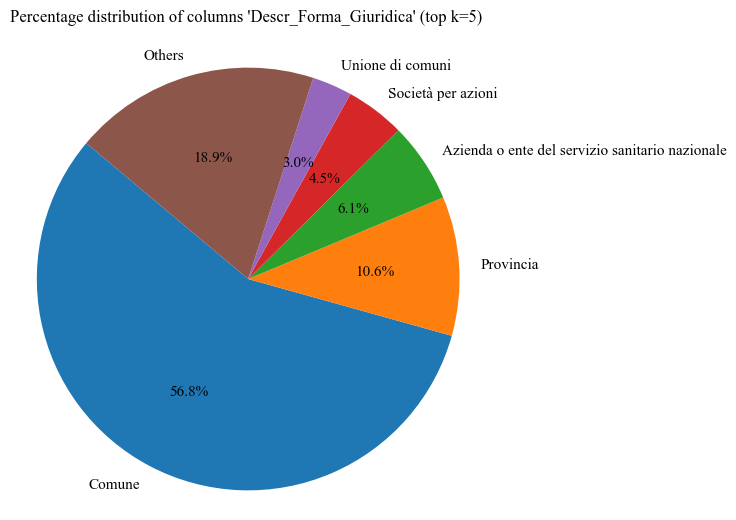

In [448]:
# Compute stats on columns
print(">> Stats on columns")
k = 5
df_stat = extract_top_k_and_sum_others(df_od_join_3, "Descr_Forma_Giuridica", k)
# print(df_stat.columns) # debug
# col_out = f"Descr_Forma_Giuridica_percentage"
create_pie_chart_from_result(df_stat, "Descr_Forma_Giuridica", "Descr_Forma_Giuridica_percentage", plots_dir, k)

In [431]:
# Filter for municipalities (Descr_Forma_Giuridica == "COMUNE")
df_od_join_4 = df_od_join_3[(df_od_join_3["Descr_Forma_Giuridica"] == "Comune") | (df_od_join_3["Descr_Forma_Giuridica"] == "Città metropolitana")]
print("Final dataframe dimension:",df_od_join_3.shape)
print("Final dataframe columns:",df_od_join_3.columns)
df_od_join_4["Descr_Forma_Giuridica"].unique()

Final dataframe dimension: (118739, 156)
Final dataframe columns: Index(['cig', 'cig_accordo_quadro', 'numero_gara', 'importo_complessivo_gara',
       'n_lotti_componenti', 'oggetto_lotto', 'importo_lotto',
       'oggetto_principale_contratto', 'settore', 'luogo_istat',
       ...
       'ribasso_aggiudicazione', 'num_imprese_offerenti', 'flag_subappalto',
       'id_aggiudicazione', 'cod_esito', 'num_imprese_richiedenti',
       'asta_elettronica', 'num_imprese_invitate', 'massimo_ribasso',
       'minimo_ribasso'],
      dtype='object', length=156)


array(['Comune', 'Città metropolitana'], dtype=object)

>> Stats on columns
Stats on column: {'Codice NUTS3 2024': 10}
Top-k: 10


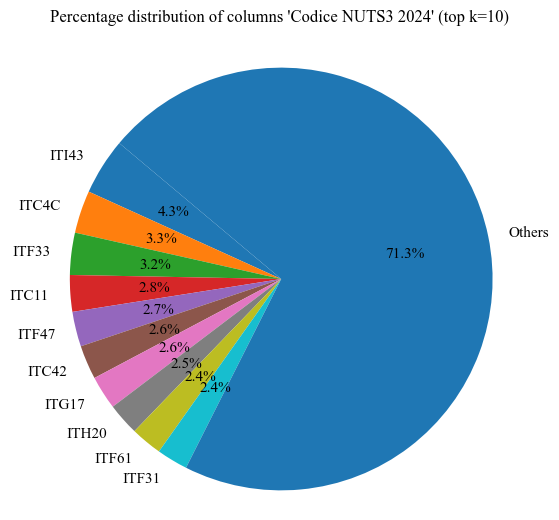

Stats on column: {'Dizione_zona': 5}
Top-k: 5


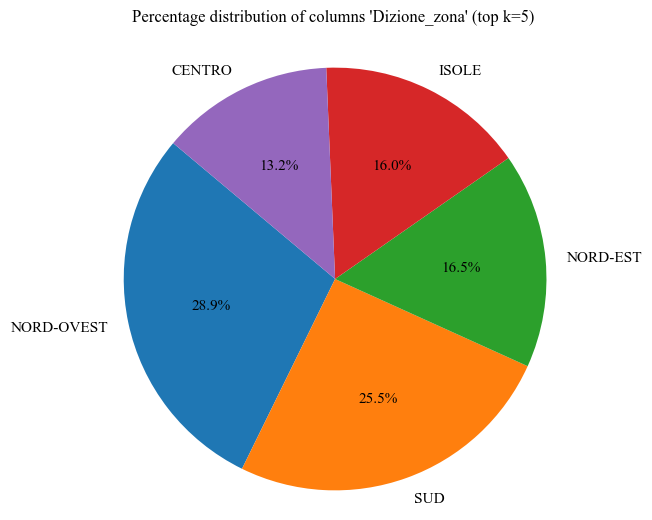

Stats on column: {'accordo_quadro': 5}
Top-k: 5


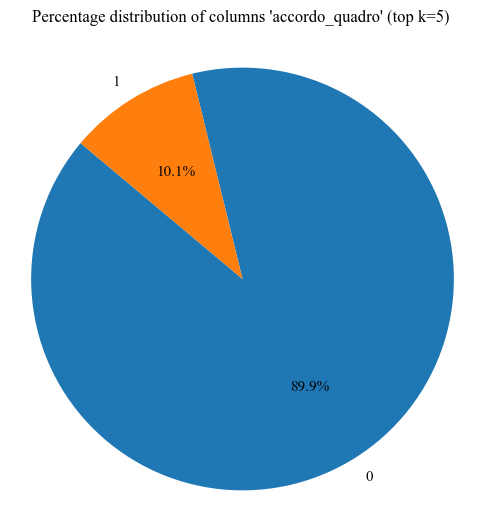

Stats on column: {'asta_elettronica': 5}
Top-k: 5


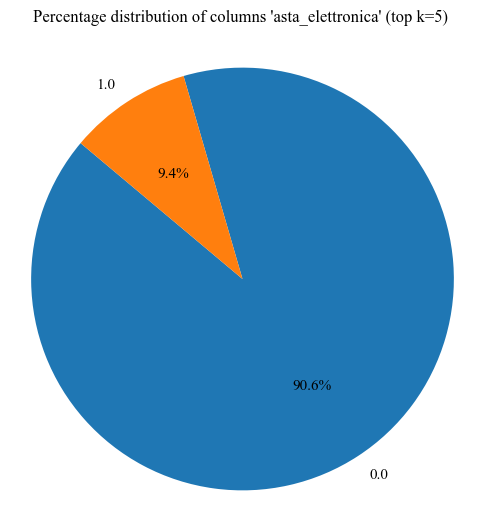

Stats on column: {'cpv_division': 5}
Top-k: 5


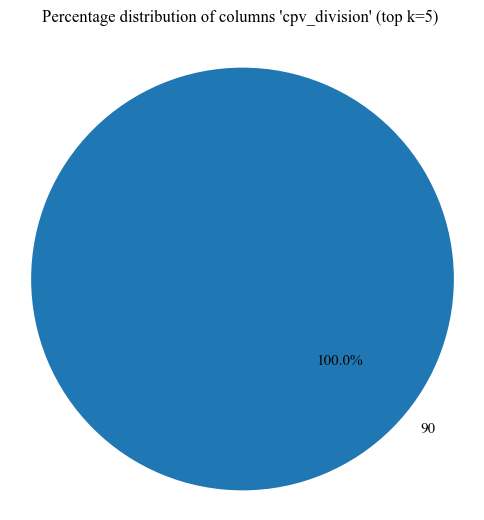

Stats on column: {'criterio_aggiudicazione': 5}
Top-k: 5


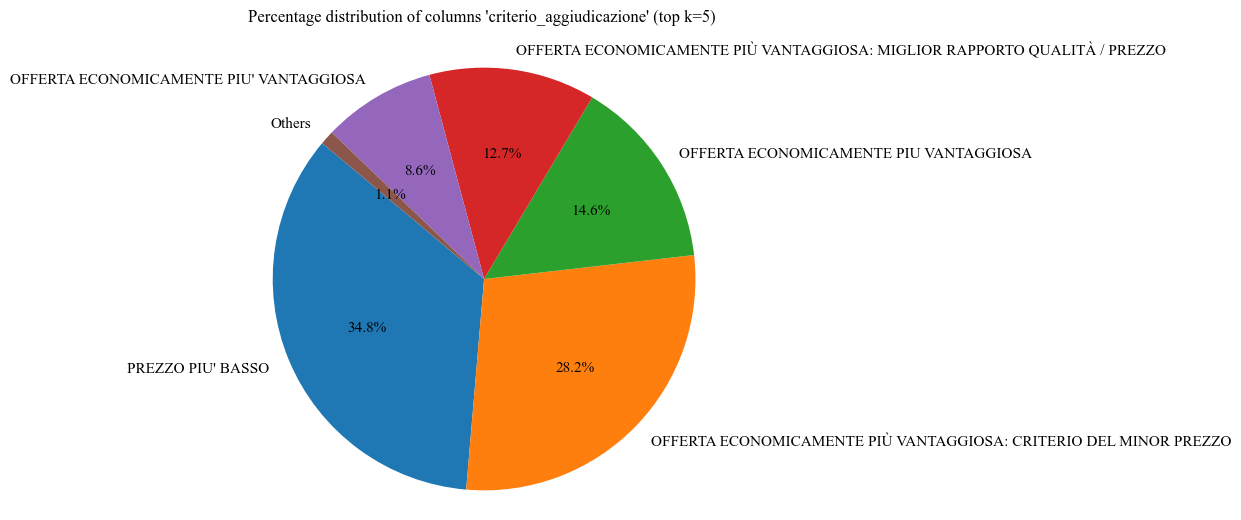

Stats on column: {'modalita_realizzazione': 5}
Top-k: 5


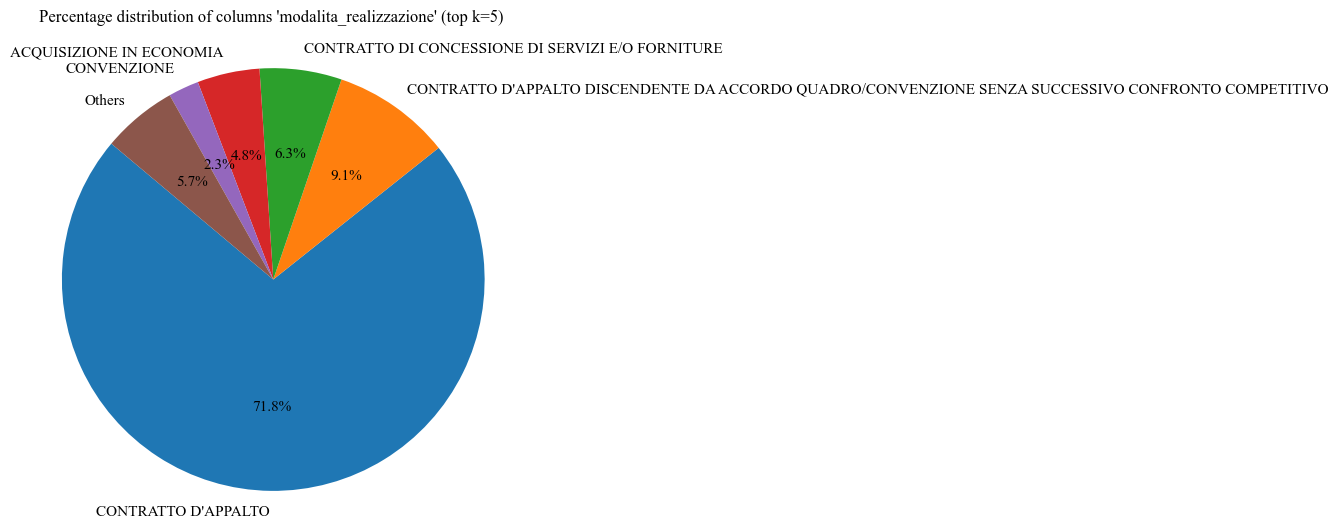

Stats on column: {'numero_offerte_ammesse': 5}
Top-k: 5


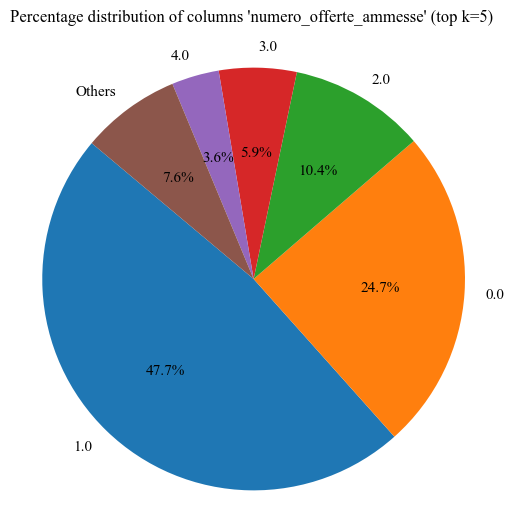

Stats on column: {'numero_offerte_escluse': 5}
Top-k: 5


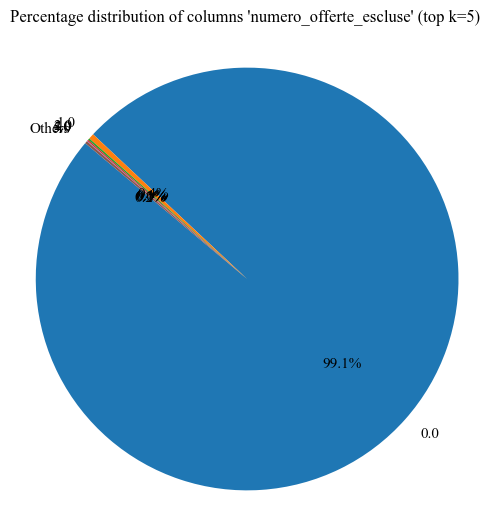

Stats on column: {'oggetto_principale_contratto': 5}
Top-k: 5


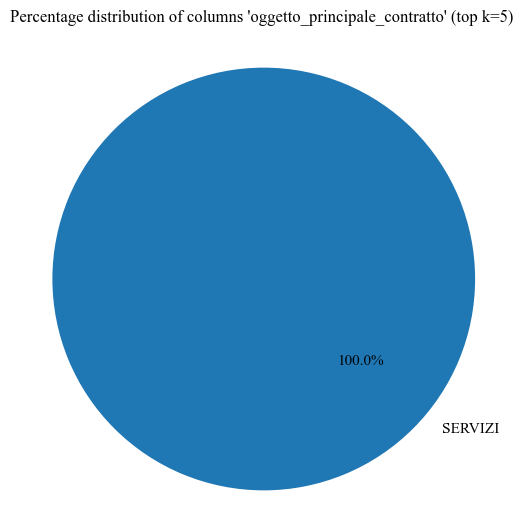

Stats on column: {'ribasso_aggiudicazione': 5}
Top-k: 5


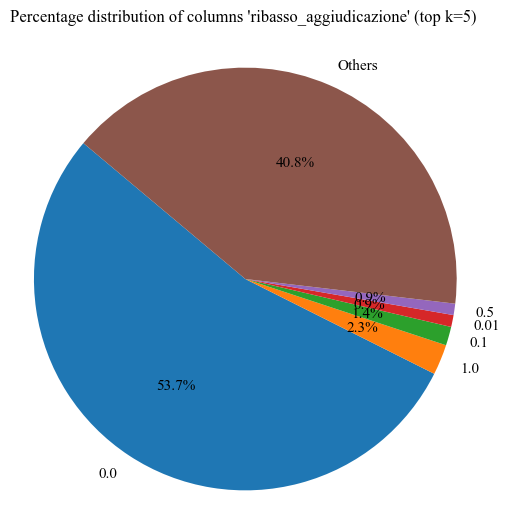

Stats on column: {'settore': 2}
Top-k: 2


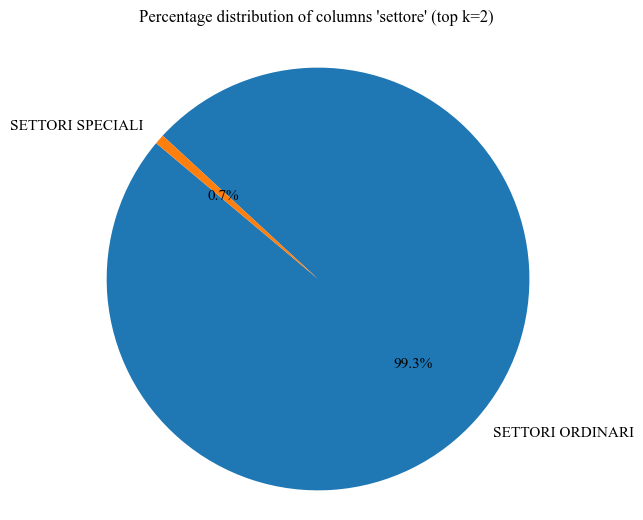

Stats on column: {'tipo_scelta_contraente': 5}
Top-k: 5


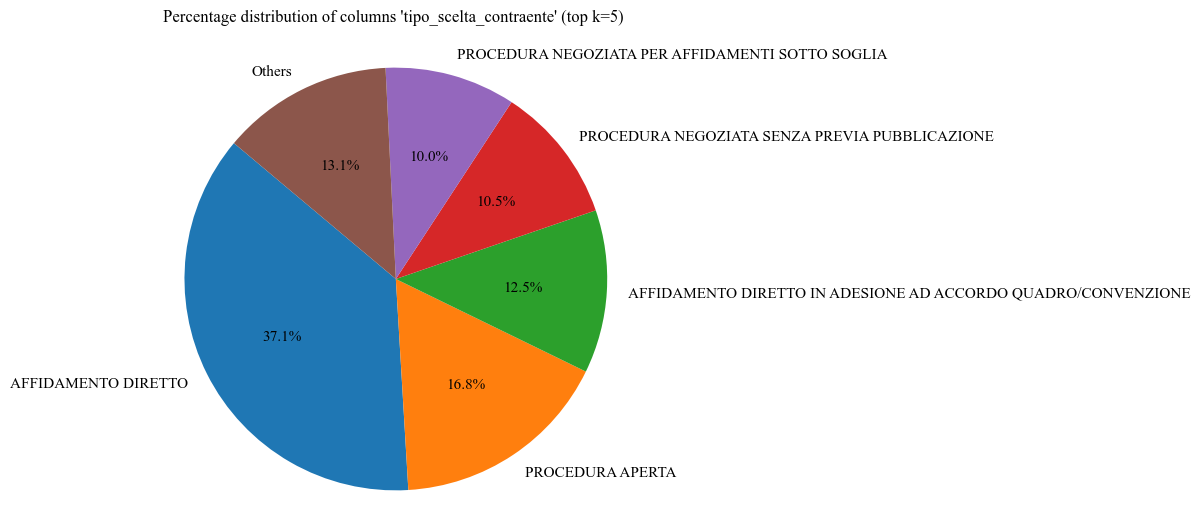

In [447]:
print(">> Stats on columns")

list_col_stat = json_to_list_dict(conf_file_stats) # col:top-k

for col_dict in list_col_stat:
    print("Stats on column:", col_dict)
    col_stat = next(iter(col_dict)) # get key name
    col_k = col_dict[col_stat] # get key value
    print("Top-k:", col_k)
    df_stat = extract_top_k_and_sum_others(df_od_join_4, col_stat, col_k)
    # print(df_stat.columns) # debug
    col_stat_p = f"{col_stat}_percentage"
    create_pie_chart_from_result(df_stat, col_stat, col_stat_p, plots_dir, col_k)